### import & 데이터 가져오기 & 데이터 합치기 & 형식 변환

In [34]:
# 데이터 처리
import pandas as pd
import numpy as np

# 머신러닝
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
import lightgbm as lgb

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 기타
from datetime import datetime

In [35]:
customers_df = pd.read_csv("olist_customers_dataset.csv")
geo_df =  pd.read_csv("olist_geolocation_dataset.csv")
order_items_df =  pd.read_csv("olist_order_items_dataset.csv")
order_payments_df =  pd.read_csv("olist_order_payments_dataset.csv")
order_reviews_df =  pd.read_csv("olist_order_reviews_dataset.csv")
orders_df =  pd.read_csv("olist_orders_dataset.csv")
products_df =  pd.read_csv("olist_products_dataset.csv")
sellers_df =  pd.read_csv("olist_sellers_dataset.csv")
category_name_df =  pd.read_csv("product_category_name_translation.csv")

In [36]:
# 주문(orders)을 중심으로 아이템(items)과 리뷰(reviews) 합치기

main_df = pd.merge(orders_df, order_items_df, on='order_id', how='left')
main_df = pd.merge(main_df, order_reviews_df, on='order_id', how='left')
main_df = pd.merge(main_df, order_payments_df, on='order_id', how='left')

# 날짜 데이터 형식 변환 
main_df['order_purchase_timestamp'] = pd.to_datetime(main_df['order_purchase_timestamp'])
main_df['order_delivered_customer_date'] = pd.to_datetime(main_df['order_delivered_customer_date'])
main_df['order_estimated_delivery_date'] = pd.to_datetime(main_df['order_estimated_delivery_date'])
main_df['shipping_limit_date'] = pd.to_datetime(main_df['shipping_limit_date'])

### 결측치 처리 (= 지연 여부와 리뷰 점수가 없는 데이터 )

In [37]:
# 배송 지연 여부를 판단할 수 없는 데이터 제거 _ 실제 배송일이 없는 경우
main_df = main_df.dropna(subset=['order_delivered_customer_date', 'shipping_limit_date'])

# 리뷰 점수가 없는 데이터 제거
main_df = main_df.dropna(subset=['review_score'])

# 리뷰 메시지 결측치는 '내용 없음'으로 채우기 
main_df['review_comment_message'] = main_df['review_comment_message'].fillna('')

print(f"통합 및 정제 완료 데이터: {len(main_df)}")

통합 및 정제 완료 데이터: 114861


### 지연 지표 생성 및 확인 

In [38]:
# 예정일보다 실제 배송일이 늦었으면 True, 아니면 False
main_df['is_delayed'] = main_df['order_delivered_customer_date'] > main_df['order_estimated_delivery_date']

# 리뷰 메시지가 있는지 여부 확인
main_df['has_review_message'] = main_df['review_comment_message'] != ''

In [39]:
# True(지연)와 False(정상)의 개수 및 비율 확인
delay_counts = main_df['is_delayed'].value_counts()
delay_rates = main_df['is_delayed'].value_counts(normalize=True) * 100

print("--- 배송 지연 여부(is_delayed) 분포 ---")
print(f"개수 합계:\n{delay_counts}")
print(f"\n비율(%%):\n{delay_rates.round(2)}")

--- 배송 지연 여부(is_delayed) 분포 ---
개수 합계:
is_delayed
False    105998
True       8863
Name: count, dtype: int64

비율(%%):
is_delayed
False    92.28
True      7.72
Name: proportion, dtype: float64


In [40]:
# 지연된 데이터(True)와 정상 데이터(False) 확인

check_cols = ['order_id', 'order_estimated_delivery_date', 'order_delivered_customer_date', 'is_delayed']

print("\n--- 지연 데이터(True) ---")
print(main_df[main_df['is_delayed'] == True][check_cols].head())

print("\n--- 정상 데이터(False) ---")
print(main_df[main_df['is_delayed'] == False][check_cols].head())


--- 지연 데이터(True) ---
                            order_id order_estimated_delivery_date  \
26  203096f03d82e0dffbc41ebc2e2bcfb7                    2017-09-28   
31  fbf9ac61453ac646ce8ad9783d7d0af6                    2018-03-12   
42  8563039e855156e48fccee4d611a3196                    2018-03-20   
48  6ea2f835b4556291ffdc53fa0b3b95e8                    2017-12-21   
65  66e4624ae69e7dc89bd50222b59f581f                    2018-04-02   

   order_delivered_customer_date  is_delayed  
26           2017-10-09 22:23:00        True  
31           2018-03-21 22:03:00        True  
42           2018-03-20 00:59:00        True  
48           2017-12-28 18:59:00        True  
65           2018-04-03 13:28:00        True  

--- 정상 데이터(False) ---
                           order_id order_estimated_delivery_date  \
0  e481f51cbdc54678b7cc49136f2d6af7                    2017-10-18   
1  e481f51cbdc54678b7cc49136f2d6af7                    2017-10-18   
2  e481f51cbdc54678b7cc49136f2d6af7          

### 지연 많이 일으키는 셀러 10

In [51]:
# 셀러별 지연 통계 계산
seller_ranking = main_df.groupby('seller_id').agg({
    'order_id': 'nunique',        # 총 주문 건수
    'is_delayed': ['sum', 'mean'] # 지연 건수 합계, 지연율(평균)
}).reset_index()

# 컬럼명 정리
seller_ranking.columns = ['seller_id', 'total_orders', 'delay_count', 'delay_rate']

# delay_rate 백분율(%)로 변환
seller_ranking['delay_rate_pct'] = (seller_ranking['delay_rate'] * 100).round(0)

# 분석 신뢰도를 위해 최소 주문 건수(10건 이상) 기준 설정
top_risk_sellers = seller_ranking[seller_ranking['total_orders'] >= 10].sort_values(by='delay_rate_pct', ascending=False)

print("--- [지연율이 높은 '유의 판매자' TOP 10 (%) ---")
print(top_risk_sellers[['seller_id', 'total_orders', 'delay_count', 'delay_rate_pct']].head(10))

--- [지연율이 높은 '유의 판매자' TOP 10 (%) ---
                             seller_id  total_orders  delay_count  \
2049  b1b3948701c5c72445495bd161b83a4c            14            9   
450   2709af9587499e95e803a6498a5a56e9            24           23   
2265  c37b2059d4f90d4feead554e5246565e            12            7   
31    02dcd3e8e25bee036e32512bcf175493            13            7   
2868  f76a3b1349b6df1ee875d1f3fa4340f0            24           10   
30    02d35243ea2e497335cd0f076b45675d            14            6   
1553  835f0f7810c76831d6c7d24c7a646d4d            42           19   
2455  d32e3909cfb714fb2a6cb092c85b9c5f            10            5   
2370  cb41bfbcbda0aea354a834ab222f9a59            11            4   
1719  91f0eec23d4a61d7d7caeefa3f0ad1ca            11            4   

      delay_rate_pct  
2049            64.0  
450             50.0  
2265            44.0  
31              41.0  
2868            40.0  
30              38.0  
1553            37.0  
2455            36.

In [52]:
# delay_count : 지연 건수 합계 (실제 배송일이 늦어진 주문의 총 개수)
# delay_rate : 지연율 (지연건수 / 총 주문 건수) 

### 배송 지연 여부에 따른 리뷰 점수 분포 

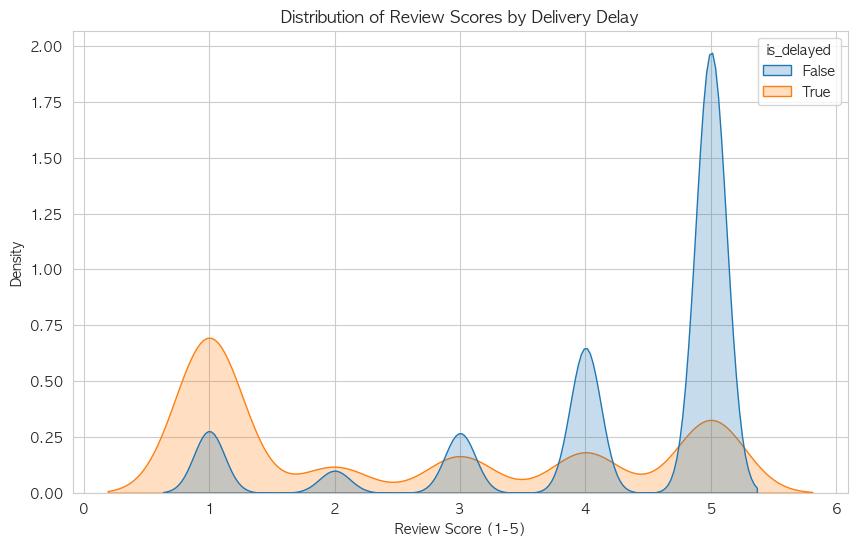

--- 지연 여부 별 리뷰 점수 개수 ---
review_score   1.0   2.0   3.0    4.0    5.0
is_delayed                                  
False         8965  3206  8670  21068  64089
True          4156   693   980   1082   1952


In [53]:
# 지연이 발생했을 때 평점이 어느 구간으로 가장 많이 쏠리는지 확인 
# 유의 판매자가 플랫폼에 입히는 평판 타격 

# 지연 여부에 따른 리뷰 점수 분포 (Density Plot)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=main_df, x='review_score', hue='is_delayed', common_norm=False, fill=True)
plt.title('Distribution of Review Scores by Delivery Delay')
plt.xlabel('Review Score (1-5)')
plt.ylabel('Density')
plt.show()

# 수치로 확인 (지연 여부별 평점 빈도)
score_dist = main_df.groupby(['is_delayed', 'review_score']).size().unstack(fill_value=0)
print("--- 지연 여부 별 리뷰 점수 개수 ---")
print(score_dist)

In [54]:
# 지연시 (true) 2.54로 급락. 
# 지연이 고객 만족도를 파괴하는 가장 결정적인 요인 

# 정상 배송은 5점에 압도적으로 몰려있음 
# 배송지연은 주황색은 1점에 높은 밀도 
# 만족도를 점진적으로 깎는게 아니라 극단적으로 폭발 

### 리뷰 메세지 유무에 따른 분포 

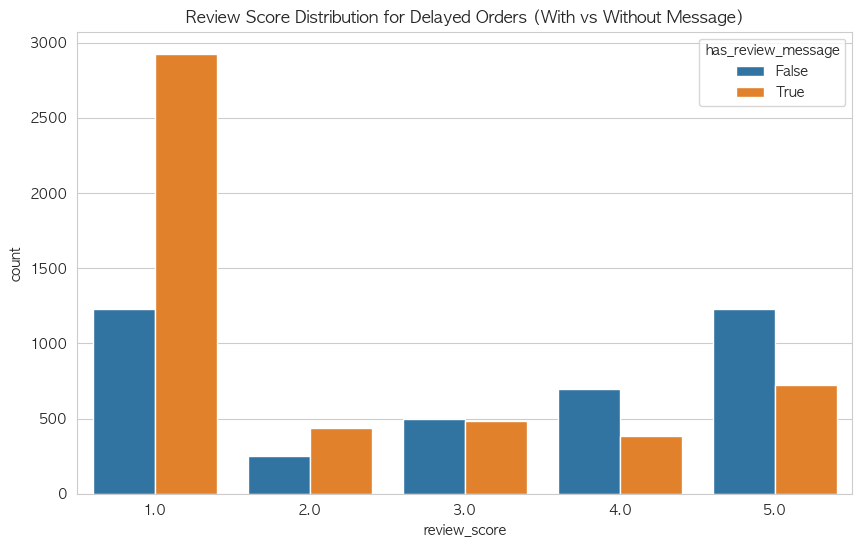

In [55]:
# 고객이 직접 불만을 텍스트로 남김  = 위험 신호 (가 지연과 만났을 때의 분포)

# 지연된 주문(is_delayed=True)만 추출하여 메시지 유무에 따른 점수 분포 확인
delayed_orders = main_df[main_df['is_delayed'] == True]

plt.figure(figsize=(10, 6))
sns.countplot(data=delayed_orders, x='review_score', hue='has_review_message')
plt.title('Review Score Distribution for Delayed Orders (With vs Without Message)')
plt.show()

In [46]:
# 배송 지연 시, 리뷰 메세지 남긴 고객의 평점은 매우 낮음 (없는 고객보다 1점정도 낮음) 
# 능동적 표현  => 플랫폼 이탈 가능성 높음 

### 손익 연계 _ 결제 금액 분포 확인

In [47]:
# 고액 결제 건이 지연될 때 리스크가 더 큰지 확인하기 위함 _ 결제 금액의 분포 확인

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


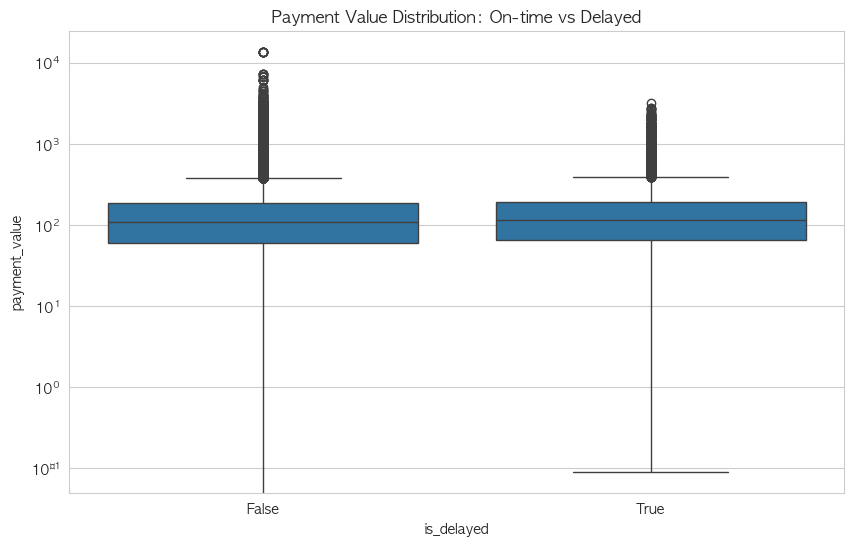

In [59]:
# 결제 금액 분포 (로그 스케일 적용하여 이상치 영향 감소)
plt.figure(figsize=(10, 6))
sns.boxplot(data=main_df, x='is_delayed', y='payment_value')
plt.yscale('log') # 금액 차이가 크므로 로그 스케일 사용
plt.title('Payment Value Distribution: On-time vs Delayed')
plt.show()

In [60]:
# 지연 주문 평균 결제 금액이 정상 주문보다 약간 더 높음 
# 비싼 물건을 산 고객들도 지연 리스크에 노출되어 있음 

In [61]:
# 결론 
# 지연율이 높으며 판매 금액이 큰 셀러  = 유의 판매자 

### 리뷰 메세지 유무에 따른 점수차이 

In [62]:
# 1. main_df에서 지연된 주문(is_delayed)만 필터링
delayed_orders = main_df[main_df['is_delayed'] == True].copy()

# 2. 메시지 유무(has_review_message)에 따른 리뷰 점수 통계
message_diff = delayed_orders.groupby('has_review_message')['review_score'].agg(['mean', 'count']).reset_index()

# 3. 결과 출력
print("--- 배송 지연 시, 리뷰 유무에 따른 평점 차이 ---")
print(message_diff)

# 4. 점수 차이 계산
no_msg_score = message_diff.loc[message_diff['has_review_message'] == False, 'mean'].values[0]
with_msg_score = message_diff.loc[message_diff['has_review_message'] == True, 'mean'].values[0]

print(f"\n평점차이 : {no_msg_score - with_msg_score:.2f}")


--- 배송 지연 시, 리뷰 유무에 따른 평점 차이 ---
   has_review_message      mean  count
0               False  3.112506   3902
1                True  2.101391   4961

평점차이 : 1.01


In [63]:
# 단순 배송 지연보다, 지연에 대해 텍스트 리뷰를 남긴 고객의 이탈 리스크가 훨씬 큼 (주장)

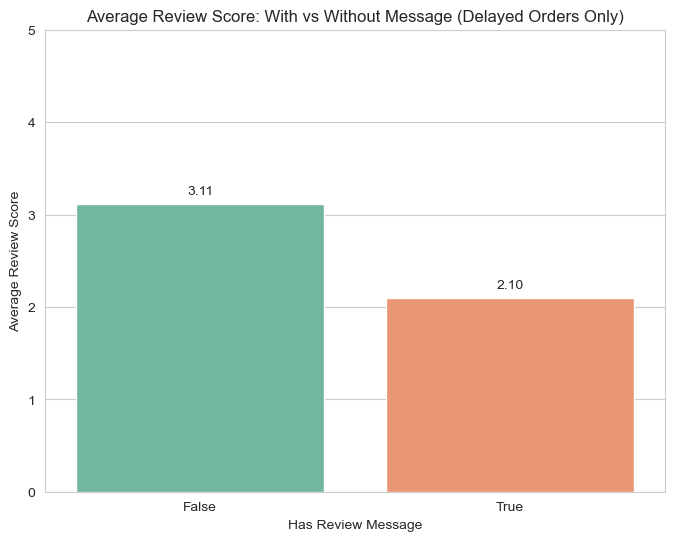

In [64]:
# 시각화
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# 막대 그래프 
ax = sns.barplot(data=message_diff, x='has_review_message', y='mean', hue='has_review_message', palette='Set2', legend=False)

# 수치 표시
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.title('Average Review Score: With vs Without Message (Delayed Orders Only)')
plt.xlabel('Has Review Message')
plt.ylabel('Average Review Score')
plt.ylim(0, 5) # 평점 범위
plt.show()

### 부정적 리뷰 (1~2점 리뷰)의 평균 손실액 & 총 손실액 

--- 1~2점 부정 리뷰 고객으로 인한 잠재적 손실 ---
1. 부정적 불만 고객 수: 3,366명
2. 1인당 평균 결제액: 188.29 BRL
3. 총 잠재적 매출 손실액: 633,208.34 BRL


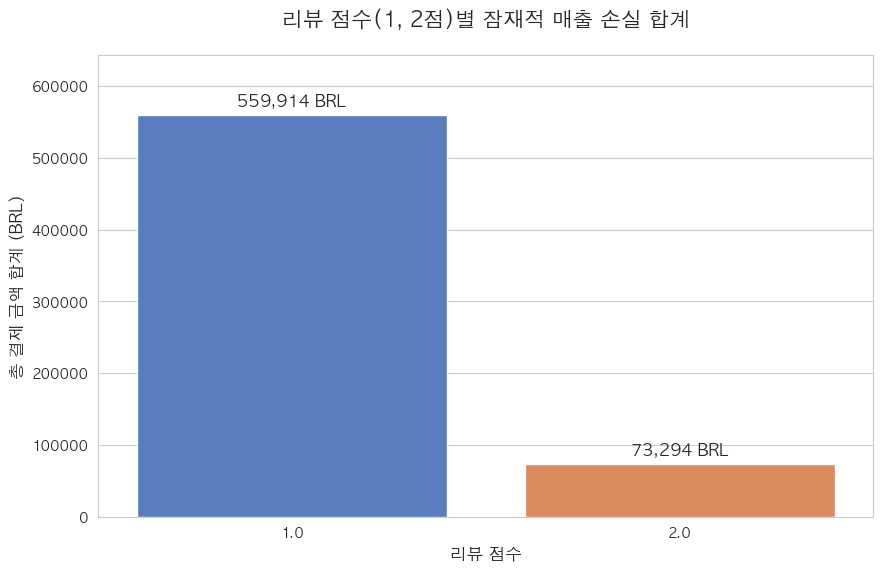

In [65]:
# 1. '부정적 불만 고객' 정의
negative_customers = main_df[
    (main_df['is_delayed'] == True) & 
    (main_df['has_review_message'] == True) & 
    (main_df['review_score'].isin([1, 2]))
]

# 2. 손실액 및 통계 계산
total_loss_value = negative_customers['payment_value'].sum()
avg_loss_per_order = negative_customers['payment_value'].mean()
customer_count = len(negative_customers)

# ★ 추가된 부분: 시각화에 사용할 loss_by_score 데이터프레임 만들기
loss_by_score = negative_customers.groupby('review_score')['payment_value'].sum().reset_index()

print(f"--- 1~2점 부정 리뷰 고객으로 인한 잠재적 손실 ---")
print(f"1. 부정적 불만 고객 수: {customer_count:,}명")
print(f"2. 1인당 평균 결제액: {avg_loss_per_order:.2f} BRL")
print(f"3. 총 잠재적 매출 손실액: {total_loss_value:,.2f} BRL")

# 3. 시각화 
sns.set_style("whitegrid")
plt.rc('font', family='AppleGothic') 
plt.figure(figsize=(10, 6))

# 막대 그래프 
ax = sns.barplot(data=loss_by_score, x='review_score', y='payment_value', 
                 hue='review_score', palette='muted', legend=False)

# 막대 위 금액 표시
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:,.0f} BRL', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=12, fontweight='bold')

# 레이블 설정
plt.title('리뷰 점수(1, 2점)별 잠재적 매출 손실 합계', fontsize=15, pad=20)
plt.xlabel('리뷰 점수', fontsize=12)
plt.ylabel('총 결제 금액 합계 (BRL)', fontsize=12)

# y축 범위 설정
plt.ylim(0, loss_by_score['payment_value'].max() * 1.15)

plt.show()

### 1-2점 (부정) + 3점 (중립) + 4~5점 (긍정) 그룹별 매출 비중 

--- [손익 분석] 리뷰 그룹별 매출 비중 ---
   리뷰 그룹  매출 합계(BRL)  주문 건수  매출 비중(%)
4-5점(긍정) 14234245.06  88191     72.37
1-2점(부정)  3816719.28  17017     19.40
  3점(중립)  1618821.96   9650      8.23


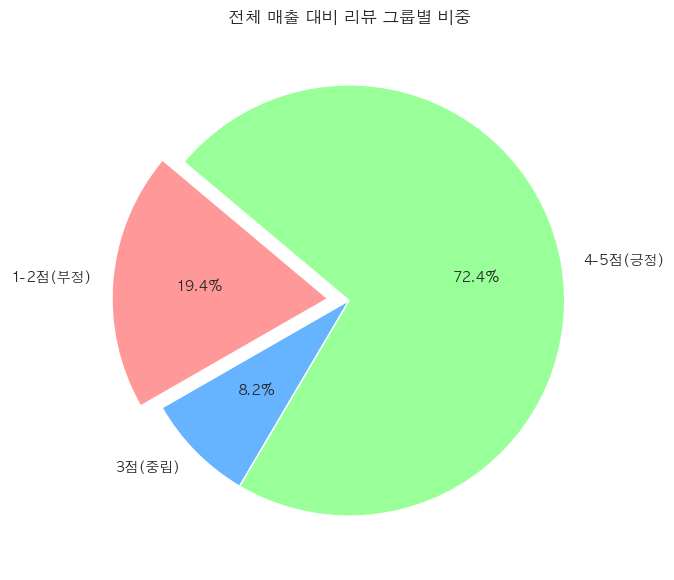

In [66]:
# 1. 리뷰 점수 그룹화 함수 정의
def categorize_score(score):
    if score <= 2: return '1-2점(부정)'
    elif score == 3: return '3점(중립)'
    else: return '4-5점(긍정)'

# 2. main_df에 그룹 컬럼 추가
main_df['score_group'] = main_df['review_score'].apply(categorize_score)

# 3. 그룹별 매출 합계 및 비중 계산
group_analysis = main_df.groupby('score_group')['payment_value'].agg(['sum', 'count']).reset_index()
total_revenue = group_analysis['sum'].sum()
group_analysis['revenue_share'] = (group_analysis['sum'] / total_revenue * 100).round(2)

# 컬럼명 정리
group_analysis.columns = ['리뷰 그룹', '매출 합계(BRL)', '주문 건수', '매출 비중(%)']

print("--- [손익 분석] 리뷰 그룹별 매출 비중 ---")
print(group_analysis.sort_values('매출 합계(BRL)', ascending=False).to_string(index=False))

# 4. 맥북용 시각화 (Pie Chart)
plt.rc('font', family='AppleGothic')
plt.figure(figsize=(10, 7))
colors = ['#ff9999','#66b3ff','#99ff99'] # 부정(빨강), 중립(파랑), 긍정(초록) 계열

plt.pie(group_analysis['매출 합계(BRL)'], labels=group_analysis['리뷰 그룹'], 
        autopct='%1.1f%%', startangle=140, colors=colors, explode=(0.1, 0, 0))
plt.title('전체 매출 대비 리뷰 그룹별 비중')
plt.show()

### 리뷰 그룹별 매출 및 주문 비중 

--- 리뷰 그룹별 매출 및 주문 비중 ---
   리뷰 그룹   총 매출(BRL)  총 주문수  매출 비중(%)  주문 비중(%)
1-2점(부정)  3816719.28  17020     19.40     14.82
  3점(중립)  1618821.96   9650      8.23      8.40
4-5점(긍정) 14234245.06  88191     72.37     76.78


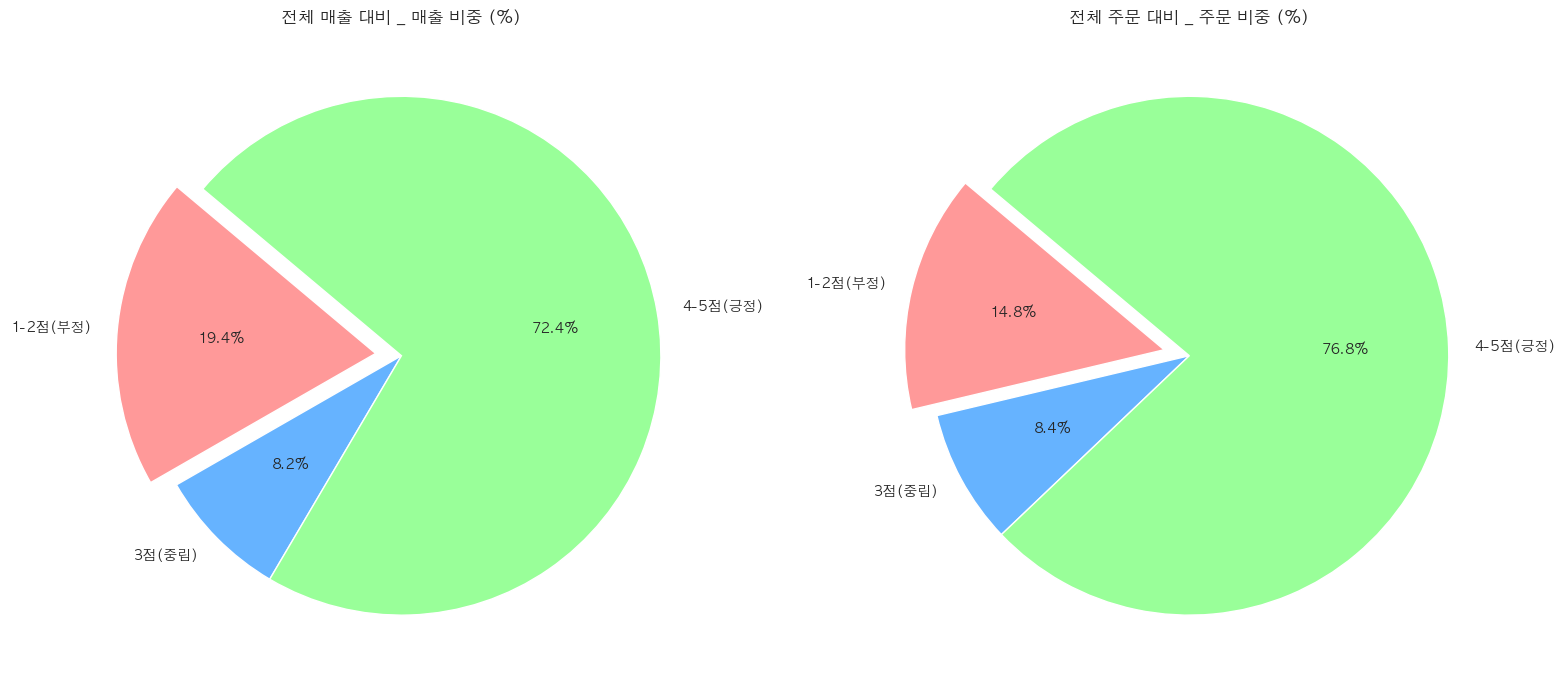

In [67]:
# 1. 그룹별 통계 계산 (매출 합계, 주문 건수)
analysis_df = main_df.groupby('score_group').agg({
    'payment_value': 'sum',
    'order_id': 'count'
}).reset_index()

# 2. 비중(%) 계산
total_revenue = analysis_df['payment_value'].sum()
total_orders = analysis_df['order_id'].sum()

analysis_df['매출 비중(%)'] = (analysis_df['payment_value'] / total_revenue * 100).round(2)
analysis_df['주문 비중(%)'] = (analysis_df['order_id'] / total_orders * 100).round(2)

# 컬럼명 정리
analysis_df.columns = ['리뷰 그룹', '총 매출(BRL)', '총 주문수', '매출 비중(%)', '주문 비중(%)']

print("--- 리뷰 그룹별 매출 및 주문 비중 ---")
print(analysis_df.to_string(index=False))

# 3. 시각화 (매출 비중 vs 주문 비중 비교)
plt.rc('font', family='AppleGothic')
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

colors = ['#ff9999','#66b3ff','#99ff99'] # 부정, 중립, 긍정

# 매출 비중 파이차트
ax[0].pie(analysis_df['총 매출(BRL)'], labels=analysis_df['리뷰 그룹'], autopct='%1.1f%%', 
          startangle=140, colors=colors, explode=(0.1, 0, 0))
ax[0].set_title('전체 매출 대비 _ 매출 비중 (%)')

# 주문 건수 비중 파이차트
ax[1].pie(analysis_df['총 주문수'], labels=analysis_df['리뷰 그룹'], autopct='%1.1f%%', 
          startangle=140, colors=colors, explode=(0.1, 0, 0))
ax[1].set_title('전체 주문 대비 _ 주문 비중 (%)')

plt.tight_layout()
plt.show()

### 리뷰 점수별 (1-5점) 매출 및 주문 비중 

--- 1~5점 점수별 매출 및 주문 비중 ---
 리뷰 점수   총 매출(BRL)  총 주문수  매출 비중(%)  주문 비중(%)
   1.0  3088160.99  13121     15.70     11.42
   2.0   728558.29   3899      3.70      3.39
   3.0  1618821.96   9650      8.23      8.40
   4.0  3618816.94  22150     18.40     19.28
   5.0 10615428.12  66041     53.97     57.50


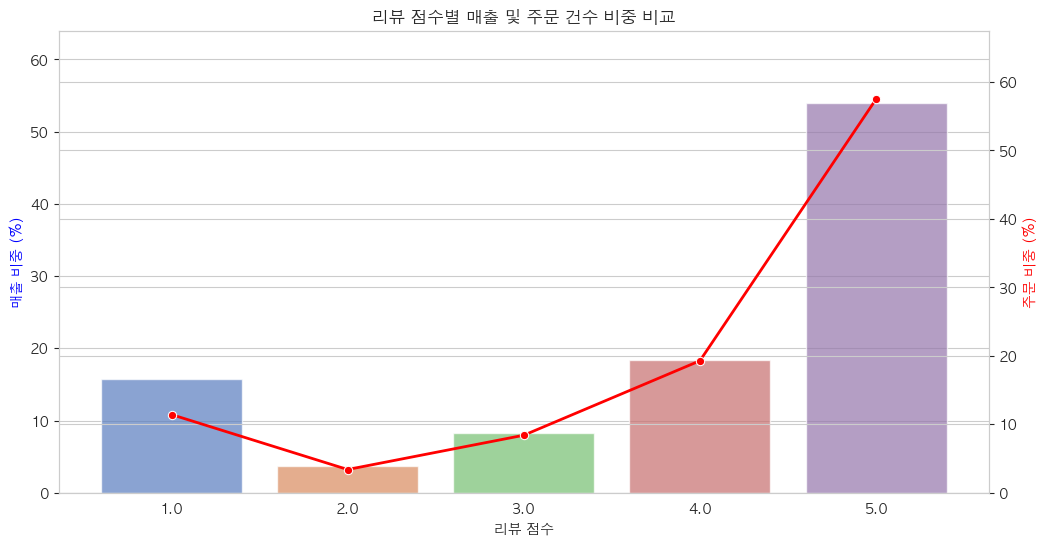

In [68]:
# 1. 점수별 매출 합계 및 주문 건수 계산
score_analysis = main_df.groupby('review_score').agg({
    'payment_value': 'sum',
    'order_id': 'count'
}).reset_index()

# 2. 전체 대비 비중(%) 계산
total_rev = score_analysis['payment_value'].sum()
total_cnt = score_analysis['order_id'].sum()

score_analysis['매출 비중(%)'] = (score_analysis['payment_value'] / total_rev * 100).round(2)
score_analysis['주문 비중(%)'] = (score_analysis['order_id'] / total_cnt * 100).round(2)

# 컬럼명 정리
score_analysis.columns = ['리뷰 점수', '총 매출(BRL)', '총 주문수', '매출 비중(%)', '주문 비중(%)']

print("--- 1~5점 점수별 매출 및 주문 비중 ---")
print(score_analysis.to_string(index=False))

# 3. 시각화 (이중축 그래프)
plt.rc('font', family='AppleGothic')
fig, ax1 = plt.subplots(figsize=(12, 6))

# 매출 비중 (막대 그래프)
sns.barplot(data=score_analysis, x='리뷰 점수', y='매출 비중(%)', alpha=0.7, ax=ax1, palette='muted',hue='리뷰 점수', legend=False)
ax1.set_ylabel('매출 비중 (%)', color='blue')
ax1.set_ylim(0, score_analysis['매출 비중(%)'].max() + 10)

# 주문 비중 (선 그래프)
ax2 = ax1.twinx()
sns.lineplot(data=score_analysis, x=score_analysis.index, y='주문 비중(%)', marker='o', color='red', ax=ax2, linewidth=2)
ax2.set_ylabel('주문 비중 (%)', color='red')
ax2.set_ylim(0, score_analysis['주문 비중(%)'].max() + 10)

plt.title('리뷰 점수별 매출 및 주문 건수 비중 비교')
plt.show()

In [69]:
# 막대 > 선 (1점 구간)= 해당 점수를 준 고객이 평균보다 더 비싼 물건을 샀음 
# = 고액 결제자일수록 지연 시 1점 줄 확률 높음 (이탈할 때 금전적 타격이 더 큼)


# 선 < 막대 (5점 구간) = 많은 사람이 주문하지만, 개별 결제 금액은 상대적으로 낮은 상품이 많음 


# 결론 : 1점 리뷰가 단순히 주문 한건의 실수가 아닌, 우리 플랫폼의 큰 손(고액 결제자)를 화나게 하고 있다 (= 이탈 중이다)

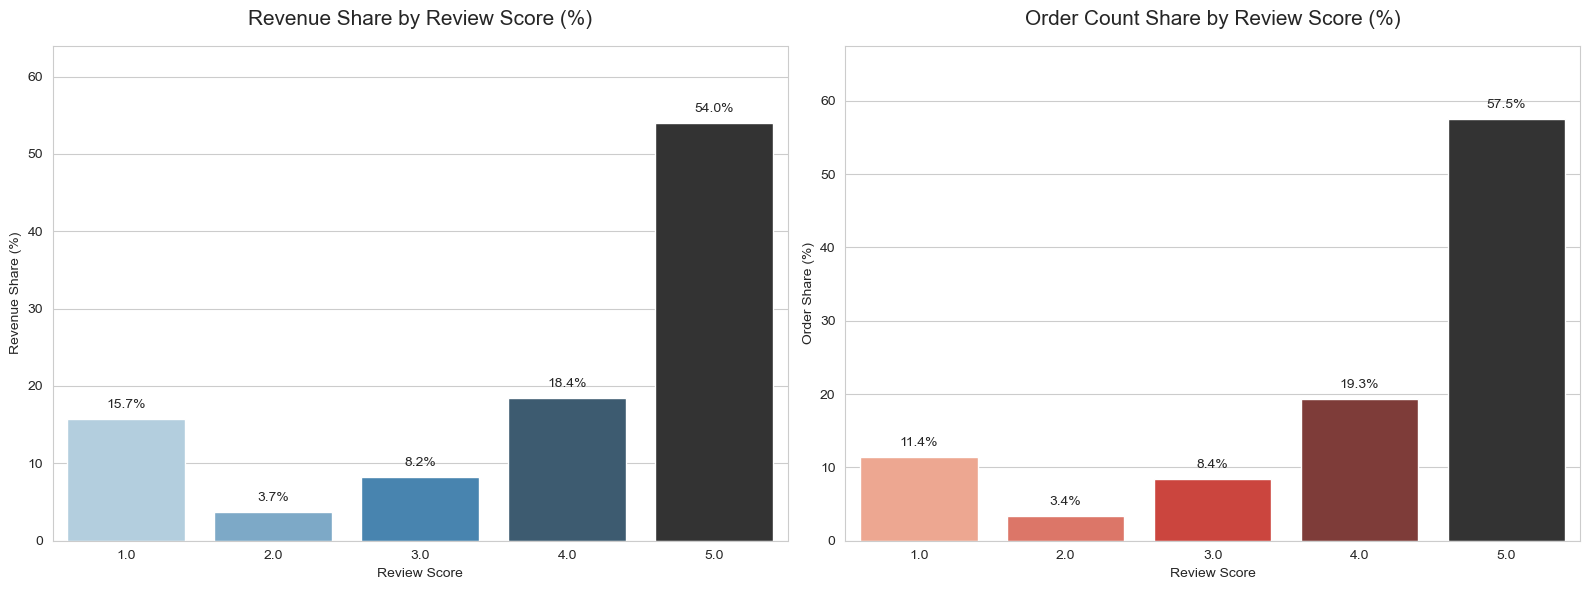

In [70]:
# 1. 시각화 스타일 설정
sns.set_style("whitegrid")

# 3. 그래프를 그릴 공간 생성 (1행 2열)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# --- 왼쪽 : 점수별 전체 매출액 대비, 매출액 비중 (%) ---
# 매출의 크기를 표현
sns.barplot(data=score_analysis, x='리뷰 점수', y='매출 비중(%)', ax=ax[0], 
            hue='리뷰 점수', palette='Blues_d', legend=False)
ax[0].set_title('Revenue Share by Review Score (%)', fontsize=15, pad=15)
ax[0].set_xlabel('Review Score')
ax[0].set_ylabel('Revenue Share (%)')
ax[0].set_ylim(0, score_analysis['매출 비중(%)'].max() + 10)

# 막대 위에 해당 퍼센트 수치 표시
for p in ax[0].patches:
    ax[0].annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# --- 오른쪽 : 점수별, 전체 주문 대비 주문 건수 비중 (%) ---
# 리스크가 있는 주문 건수를 표현
sns.barplot(data=score_analysis, x='리뷰 점수', y='주문 비중(%)', ax=ax[1], 
            hue='리뷰 점수', palette='Reds_d', legend=False)
ax[1].set_title('Order Count Share by Review Score (%)', fontsize=15, pad=15)
ax[1].set_xlabel('Review Score')
ax[1].set_ylabel('Order Share (%)')
ax[1].set_ylim(0, score_analysis['주문 비중(%)'].max() + 10)

# 막대 위에 해당 퍼센트 수치 표시
for p in ax[1].patches:
    ax[1].annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 그래프 간격 조절 및 출력
plt.tight_layout()
plt.show()

### 배송 지연 일수별 평점 하락 추이 (지연이 길어질때마다 인내심이 얼마나 깎이는지)

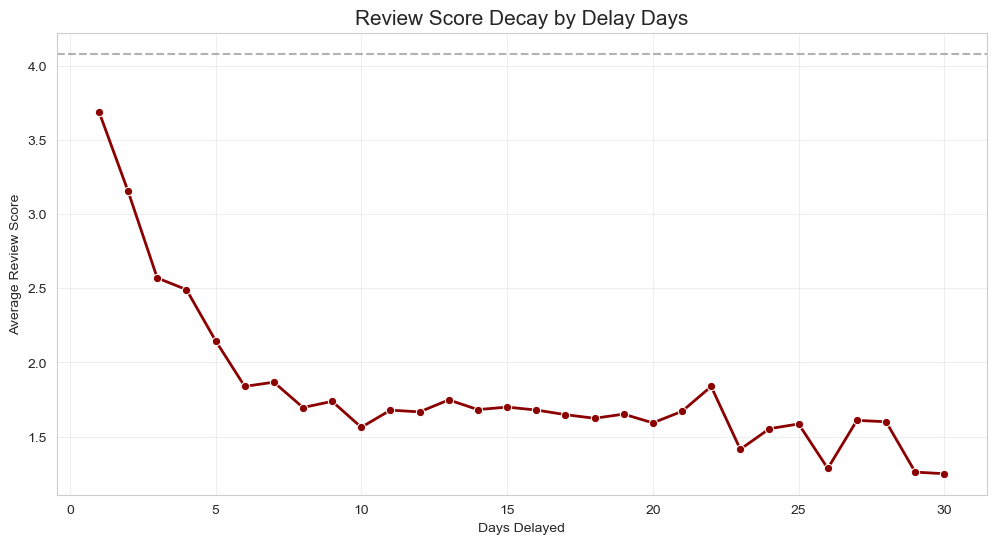

In [71]:
# 1. 지연 일수 계산 
# 실제 배송일 - 예정 배송일
main_df['delay_days'] = (main_df['order_delivered_customer_date'] - main_df['order_estimated_delivery_date']).dt.days

# 지연이 발생한 데이터만 추출 (1일 이상 지연)
delay_df = main_df[main_df['delay_days'] > 0].copy()

# 지연 일수별 평균 점수 계산 (데이터가 적은 너무 긴 지연은 30일까지 제한)
delay_trend = delay_df[delay_df['delay_days'] <= 30].groupby('delay_days')['review_score'].mean().reset_index()

# 2. 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=delay_trend, x='delay_days', y='review_score', marker='o', color='darkred', linewidth=2)

# 전체 평균선 추가 (비교용)
plt.axhline(main_df['review_score'].mean(), color='gray', linestyle='--', alpha=0.6)

plt.title('Review Score Decay by Delay Days', fontsize=15)
plt.xlabel('Days Delayed')
plt.ylabel('Average Review Score')
plt.grid(True, alpha=0.3)
plt.show()

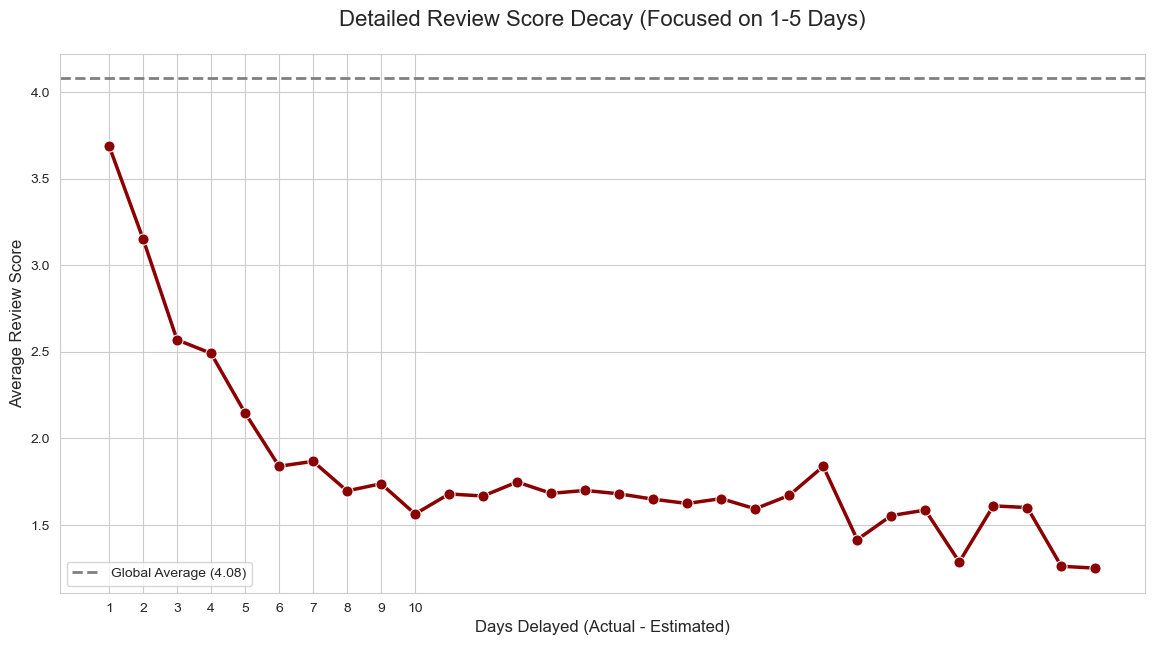

In [72]:
# 일 별 쪼개기 (1~5일 평점 하락 상세관찰용)

# 1. 시각화
sns.set_style("whitegrid")

# 2. 그래프 크기 
plt.figure(figsize=(14, 7))

# 3. 선 그래프 (1~30일 데이터)
# delay_trend는 앞서 계산된 지연 일수별 평균 점수 
sns.lineplot(data=delay_trend, x='delay_days', y='review_score', 
             marker='o', color='darkred', linewidth=2.5, markersize=8)

# 4. 전체 평균 점선 (Threshold) 표시
avg_score = main_df['review_score'].mean()
plt.axhline(avg_score, color='gray', linestyle='--', linewidth=2, label=f'Global Average ({avg_score:.2f})')

# 5. X축 : 1~5일 구간을 더 잘 보기 위해 1일 단위로 눈금 표시
plt.xticks(range(1, 11, 1)) 

# 6. 그래프 타이틀 및 라벨 
plt.title('Detailed Review Score Decay (Focused on 1-5 Days)', fontsize=16, pad=20)
plt.xlabel('Days Delayed (Actual - Estimated)', fontsize=12)
plt.ylabel('Average Review Score', fontsize=12)

# 7. 범례 
plt.legend()

plt.show()

In [73]:
# global average (4.08) = 지연 여부 상관없이, 전체 주문에 대한 평균 리뷰 점수 
# 가장 가파른 구간 : 1~3일 사이 = 방어선 구축 시점?

In [74]:
# 지연되었는데도 4점 이상 준 경우 (긍정 지연 주문)

--- 지연에도 불구하고 4점 이상을 준 고객 ---
1. 전체 지연 주문 중 4점 이상 응답 수: 3,034건
2. 지연 주문 내 4점 이상 비중: 34.23%
3. 4점 이상 고객들 _ 평균 결제 금액: 169.32 BRL


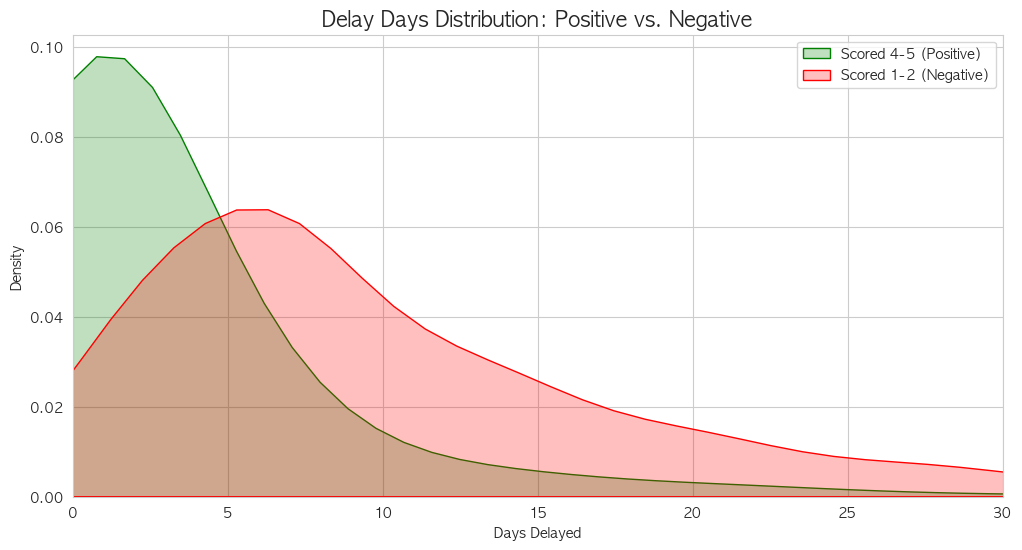

In [75]:
# 1. '긍정 지연 주문' 정의: 지연되었음에도 불구하고 점수가 4점 또는 5점인 경우
loyal_delayed_df = main_df[
    (main_df['is_delayed'] == True) & 
    (main_df['review_score'] >= 4)
].copy()

# 2. 주요 통계 확인
total_delayed_count = len(main_df[main_df['is_delayed'] == True])
loyal_count = len(loyal_delayed_df)
loyal_ratio = (loyal_count / total_delayed_count * 100)

print(f"--- 지연에도 불구하고 4점 이상을 준 고객 ---")
print(f"1. 전체 지연 주문 중 4점 이상 응답 수: {loyal_count:,}건")
print(f"2. 지연 주문 내 4점 이상 비중: {loyal_ratio:.2f}%")
print(f"3. 4점 이상 고객들 _ 평균 결제 금액: {loyal_delayed_df['payment_value'].mean():.2f} BRL")

# 3. 지연 일수 분포 
plt.rc('font', family='AppleGothic')
plt.figure(figsize=(12, 6))

# 지연되었는데 4-5점 준 사람 vs 1-2점 준 사람의 지연 일수 비교
sns.kdeplot(data=main_df[(main_df['is_delayed']==True) & (main_df['review_score']>=4)], 
            x='delay_days', label='Scored 4-5 (Positive)', fill=True, color='green')
sns.kdeplot(data=main_df[(main_df['is_delayed']==True) & (main_df['review_score']<=2)], 
            x='delay_days', label='Scored 1-2 (Negative)', fill=True, color='red')

plt.title('Delay Days Distribution: Positive vs. Negative', fontsize=15)
plt.xlabel('Days Delayed')
plt.ylabel('Density')
plt.xlim(0, 30) # 30일 이내 지연
plt.legend()
plt.show()

### 4~5점 지연 고객 메세지 분석 (= 배송이 늦어도 고객을 만족시킨 비결)

--- 지연되었지만 4점 이상을 준 고객 ---
1. 4점 이상 고객 중 리뷰 작성 수: 1,110
2. 리뷰 작성 비율: 36.59%

3. 실제 리뷰 메시지 (상위 10개):
[1] há muito tempo efetuo compras atraves desta loja, nunca tive problemas. sempre entrega antes da data.
[2] Chegou antes do prazo e o produto é exatamente pedido o que eu queria
[3] muito bom otimo

[4] 
[5] Veio com a voltagem 220,sendo que pedi 110
[6] Ótimo atendimento 
[7] Produto excelente fiquei muito satisfeito.
[8] Produto de qualidade. Somente a entrega efetuada através dos Correios demorou mais de 30 dias.
[9] Só realizei a compra pq chegava antes do Natal e até agora nada de chegar. 
[10] Olha comprei 2 produto mas foi entregue só um não sei o y aconteceu esse saet sempre entregou correto.


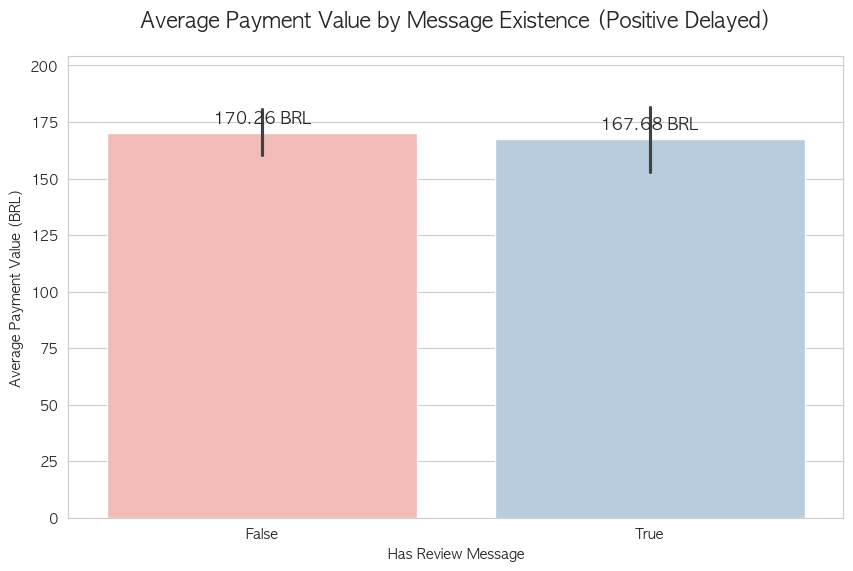

In [81]:
# 1. 긍정 지연 고객 중 메시지를 남긴 비율 확인
loyal_with_message = loyal_delayed_df[loyal_delayed_df['has_review_message'] == True]
message_ratio = (len(loyal_with_message) / len(loyal_delayed_df) * 100)

print(f"--- 지연되었지만 4점 이상을 준 고객 ---")
print(f"1. 4점 이상 고객 중 리뷰 작성 수: {len(loyal_with_message):,}")
print(f"2. 리뷰 작성 비율: {message_ratio:.2f}%")

# 2. 실제 리뷰 출력
print(f"\n3. 실제 리뷰 메시지 (상위 10개):")
sample_messages = loyal_delayed_df['review_comment_message'].dropna().unique()[:10]

for i, msg in enumerate(sample_messages):
    print(f"[{i+1}] {msg}")

# 3. 시각화: 리뷰 유무에 따른 결제 금액 차이
plt.rc('font', family='AppleGothic')
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=loyal_delayed_df, x='has_review_message', y='payment_value', 
                 hue='has_review_message', palette='Pastel1', legend=False)

# 막대 위에 평균 결제 금액 수치 표시 (천 단위 콤마 추가)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:,.2f} BRL', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=12, fontweight='bold')

plt.title('Average Payment Value by Message Existence (Positive Delayed)', fontsize=15, pad=20)
plt.xlabel('Has Review Message')
plt.ylabel('Average Payment Value (BRL)')

# y축 범위
plt.ylim(0, loyal_delayed_df.groupby('has_review_message')['payment_value'].mean().max() * 1.2)

plt.show()

In [77]:
### 가격 & 상품 개수 결합 _ 지연 주문 평점 분석